## Bayesian parameter estimation using Importance Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

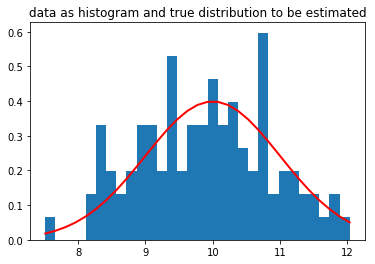

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal',
                        prior_name = ['uniform','inv_gamma'], prior_params = [[0, 15], [1, 0, 1]], 
                        prior_type='marginal_pdf')

In [4]:
# Learn the unknown parameters using IS
bayes_estimator = BayesParameterEstimation(model=candidate_model, data=data, sampling_method = 'IS', nsamples=10000)

UQpy: Running parameter estimation for candidate model: normal
marginal_pdf
after run
UQpy: Parameter estimation analysis completed!


1.0000000000000007


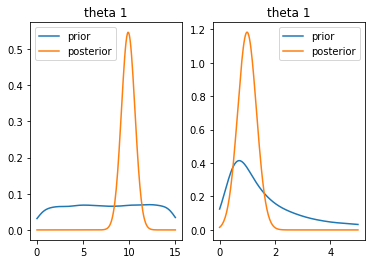

In [5]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='posterior')
ax[0].legend()
ax[0].set_title('theta 1')

domain = np.linspace(0, 5, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='posterior')
ax[1].legend()
ax[1].set_title('theta 1')

plt.show()

## Regression model

In [6]:
# Generate data from a quadratic equation, add some noise to it
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_type='python', model_script='pfn_quadratic.py')

data = z.model_eval.QOI[0]+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)

Evaluating the model...

[  1.20491406  -1.75206      1.47592918   0.82912921   3.19047185
   2.65412368   4.38228004   3.79579726   7.23935654   7.74368777
  11.24336828  11.92741718  13.15501238  15.69147078  20.53425998
  24.09598176  23.91801768  27.99186363  29.54840238  34.22590216
  36.86766791  42.36727093  43.42135805  48.90305963  51.1328536
  57.29242736  61.90937733  65.95982577  71.01395775  74.70654452
  81.64427689  85.37321129  93.17758295  94.36453424 104.42245184
 109.91496919 116.30837139 121.9091315  127.81115544 132.89476332
 139.86877435 147.21973772 154.32096076 161.25702632 169.17551319
 179.49212163 185.48862127 195.02090201 201.58003603 209.53486247]


In [7]:
candidate_model = Model(model_type='python', model_script='pfn_quadratic.py', n_params=2, 
                        error_covariance=error_covariance)

In [8]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method = 'IS', nsamples=200000,
                                           pdf_proposal = ['normal', 'normal'], pdf_proposal_params = [[0, 2], [0, 2]],
                                          pdf_proposal_type = 'marginal_pdf')

UQpy: Running parameter estimation for candidate model
marginal_pdf
after run
UQpy: Parameter estimation analysis completed!


0.9999999999999997


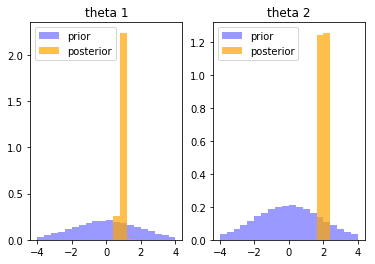

In [9]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(x=s[:,i], weights=None, density=True, range=(-4, 4), bins = 20, color='blue', alpha=0.4, label='prior')
    ax[i].hist(x=s[:,i], weights=w, density=True, range=(-4, 4), bins = 20, color='orange', alpha=0.7, label='posterior')
    ax[i].legend()
    ax[i].set_title('theta {}'.format(i+1))

plt.show()

Effective sample size is ne=19.770870978180422, for a total number of samples=200000
max_weight = 0.09083447614189373, min_weight = 0.0


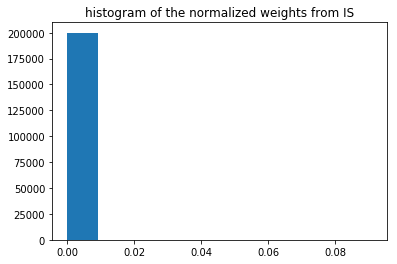

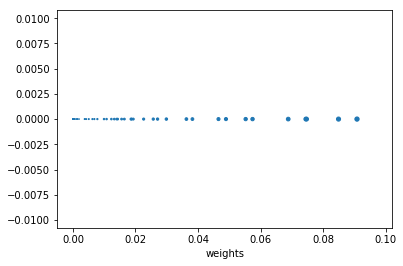

In [10]:
Diagnostics(sampling_method='IS', sampling_outputs = bayes_estimator)